In [ ]:
%load_ext autoreload
%autoreload 2


In [ ]:
import comet_ml
from comet_ml import Experiment

In [ ]:
import os,sys
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CometLogger

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 14})

In [5]:
sys.path.append('../training')
from manifoldembedder import *
from anomalymodels import *

In [6]:
basedir_toyreal = '/nobackup/users/sangeon/datasets/jets/jetpairs/realistic'

toyreal_dict = {'train':os.path.join(basedir_toyreal, 'realistic_jettrain_16part.pt'),
             'val':os.path.join(basedir_toyreal, 'realistic_jetval_16part.pt'),
             'test':os.path.join(basedir_toyreal, 'realistic_jettest_measureDistortion_16part.pt'),
             'predict':os.path.join(basedir_toyreal, 'realistic_jetpredict_16part.pt')}


toyreal = torch.load(os.path.join(basedir_toyreal, 'realistic_jettest_measureDistortion_16part.pt'))


jetreal_dm = JetDataModule(toyreal_dict,2500)


In [7]:
trainer = Trainer(gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [26]:
embedder = HyperbolicEmbedder.load_from_checkpoint("../training/simulatedtoyjets_checkpoints/Transformer-paper-hyperbolic-try4-epoch=00-val_loss=0.21.ckpt")


true
true
true
true
true
true
true
true
true
true
true
true
true
true
true


In [27]:
embedder.eval()


HyperbolicEmbedder(
  (encoder): particleTransformer(
    (embed_src): Linear(in_features=3, out_features=32, bias=True)
    (embed_tgt): Linear(in_features=3, out_features=32, bias=True)
    (pos_enc): PositionalEncoding(
      (dropout): Dropout(p=0.25, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=32, out_features=32, bias=True)
          )
          (linear1): Linear(in_features=32, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=32, bias=True)
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): T

In [57]:
a = trainer.test(embedder, jetreal_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

start
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


In [59]:
distortion = np.empty(0)
for batch in embedder.distortion_measure:
    distortion = np.concatenate([distortion,batch.cpu().numpy()])

In [60]:
pairwiseratio = np.empty(0)
for batch in embedder.pairwise_ratio:
    pairwiseratio = np.concatenate([pairwiseratio,batch.cpu().numpy()])

In [61]:
distortion

array([0.82907989, 0.77222066, 0.64763868, ..., 0.64419055, 0.68480832,
       0.81015463])

In [62]:
max(distortion)

13.927130675398418

In [63]:
min(distortion)

8.80855682983671e-07

In [64]:
np.mean(distortion)

0.5450367712732004

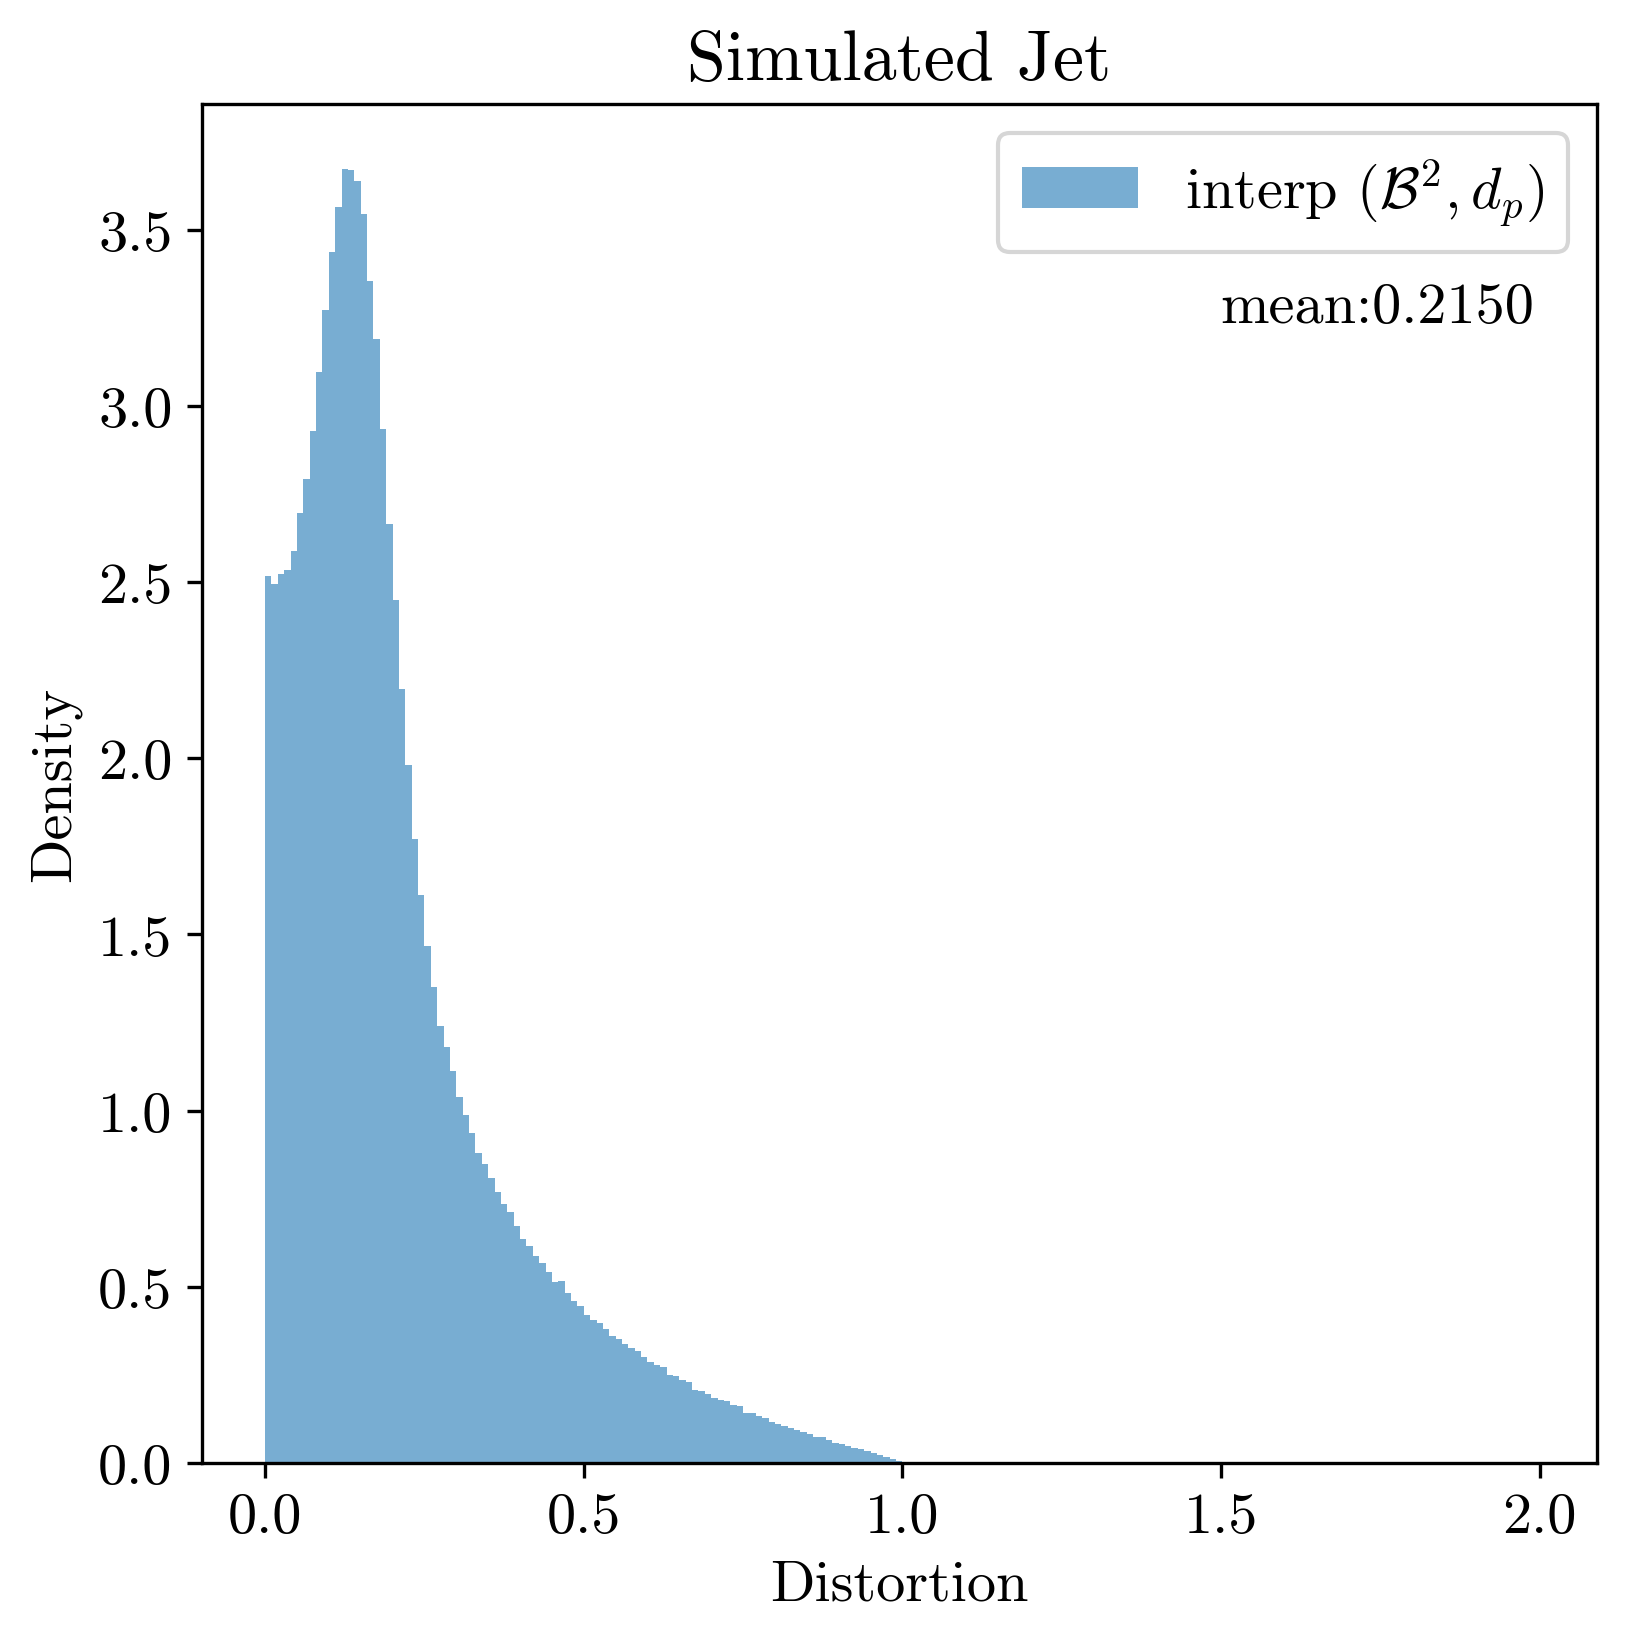

In [78]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(poin_interp_dist, bins=np.arange(0,2,0.01),alpha=0.6, density=True,label='interp $(\mathcal{B}^2, d_p)$');
ax.text(0.73, 0.85, f'mean:{np.mean(poin_interp_dist):.4f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.legend()

ax.set_xlabel("Distortion")
ax.set_ylabel("Density")
#plt.yscale('log')
ax.set_title('Simulated Jet')
#ax.legend()
plt.savefig('../figures/paper/HyperbolicDistortionInterp_SimulatedJet_Final_v0.png')
plt.savefig('../figures/paper/HyperbolicDistortionInterp_SimulatedJet_Final_v0.pdf')

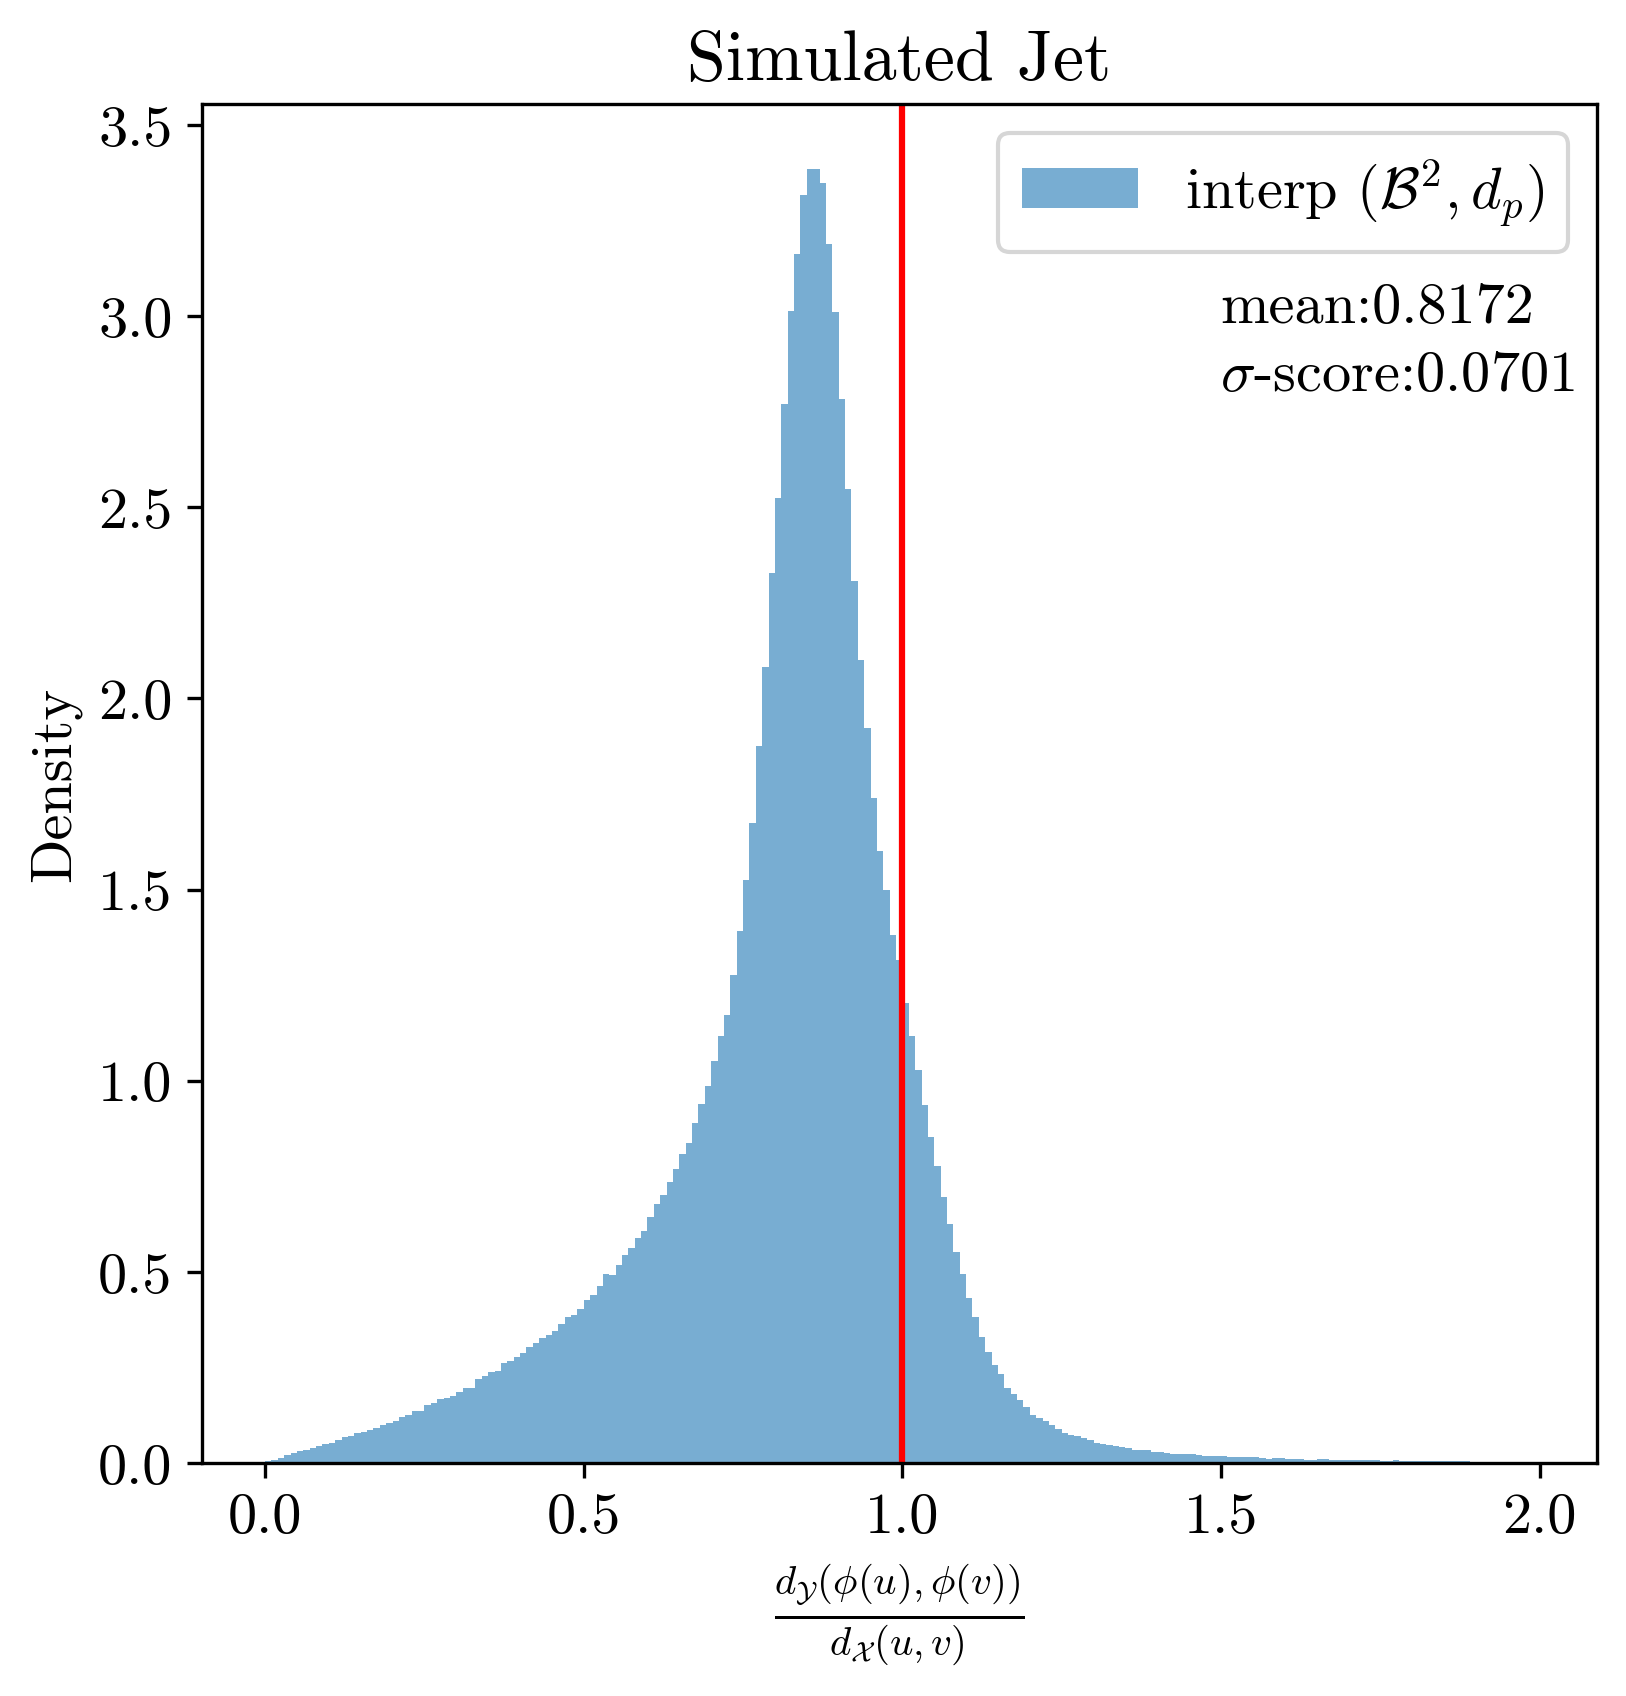

In [91]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(poin_interp_pair, bins=np.arange(0,2,0.01),alpha=0.6, density=True,label='interp $(\mathcal{B}^2, d_p)$');
ax.text(0.73, 0.85, f'mean:{np.mean(poin_interp_pair):.4f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.73, 0.8, fr'$\sigma$-score:{np.var(poin_interp_pair/np.mean(poin_interp_pair)):.4f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.axvline(1.0, c='red')

ax.legend()

ax.set_xlabel(r"$\frac{d_\mathcal{Y}({\phi(u), \phi(v)})}{d_\mathcal{X}(u,v)}$")
ax.set_ylabel("Density")
#plt.yscale('log')
ax.set_title('Simulated Jet')
#ax.legend()
plt.savefig('../figures/paper/HyperbolicPairwiseRatio_SimulatedJet_Final_v0.png')
plt.savefig('../figures/paper/HyperbolicPairwiseRatio_SimulatedJet_Final_v0.pdf')

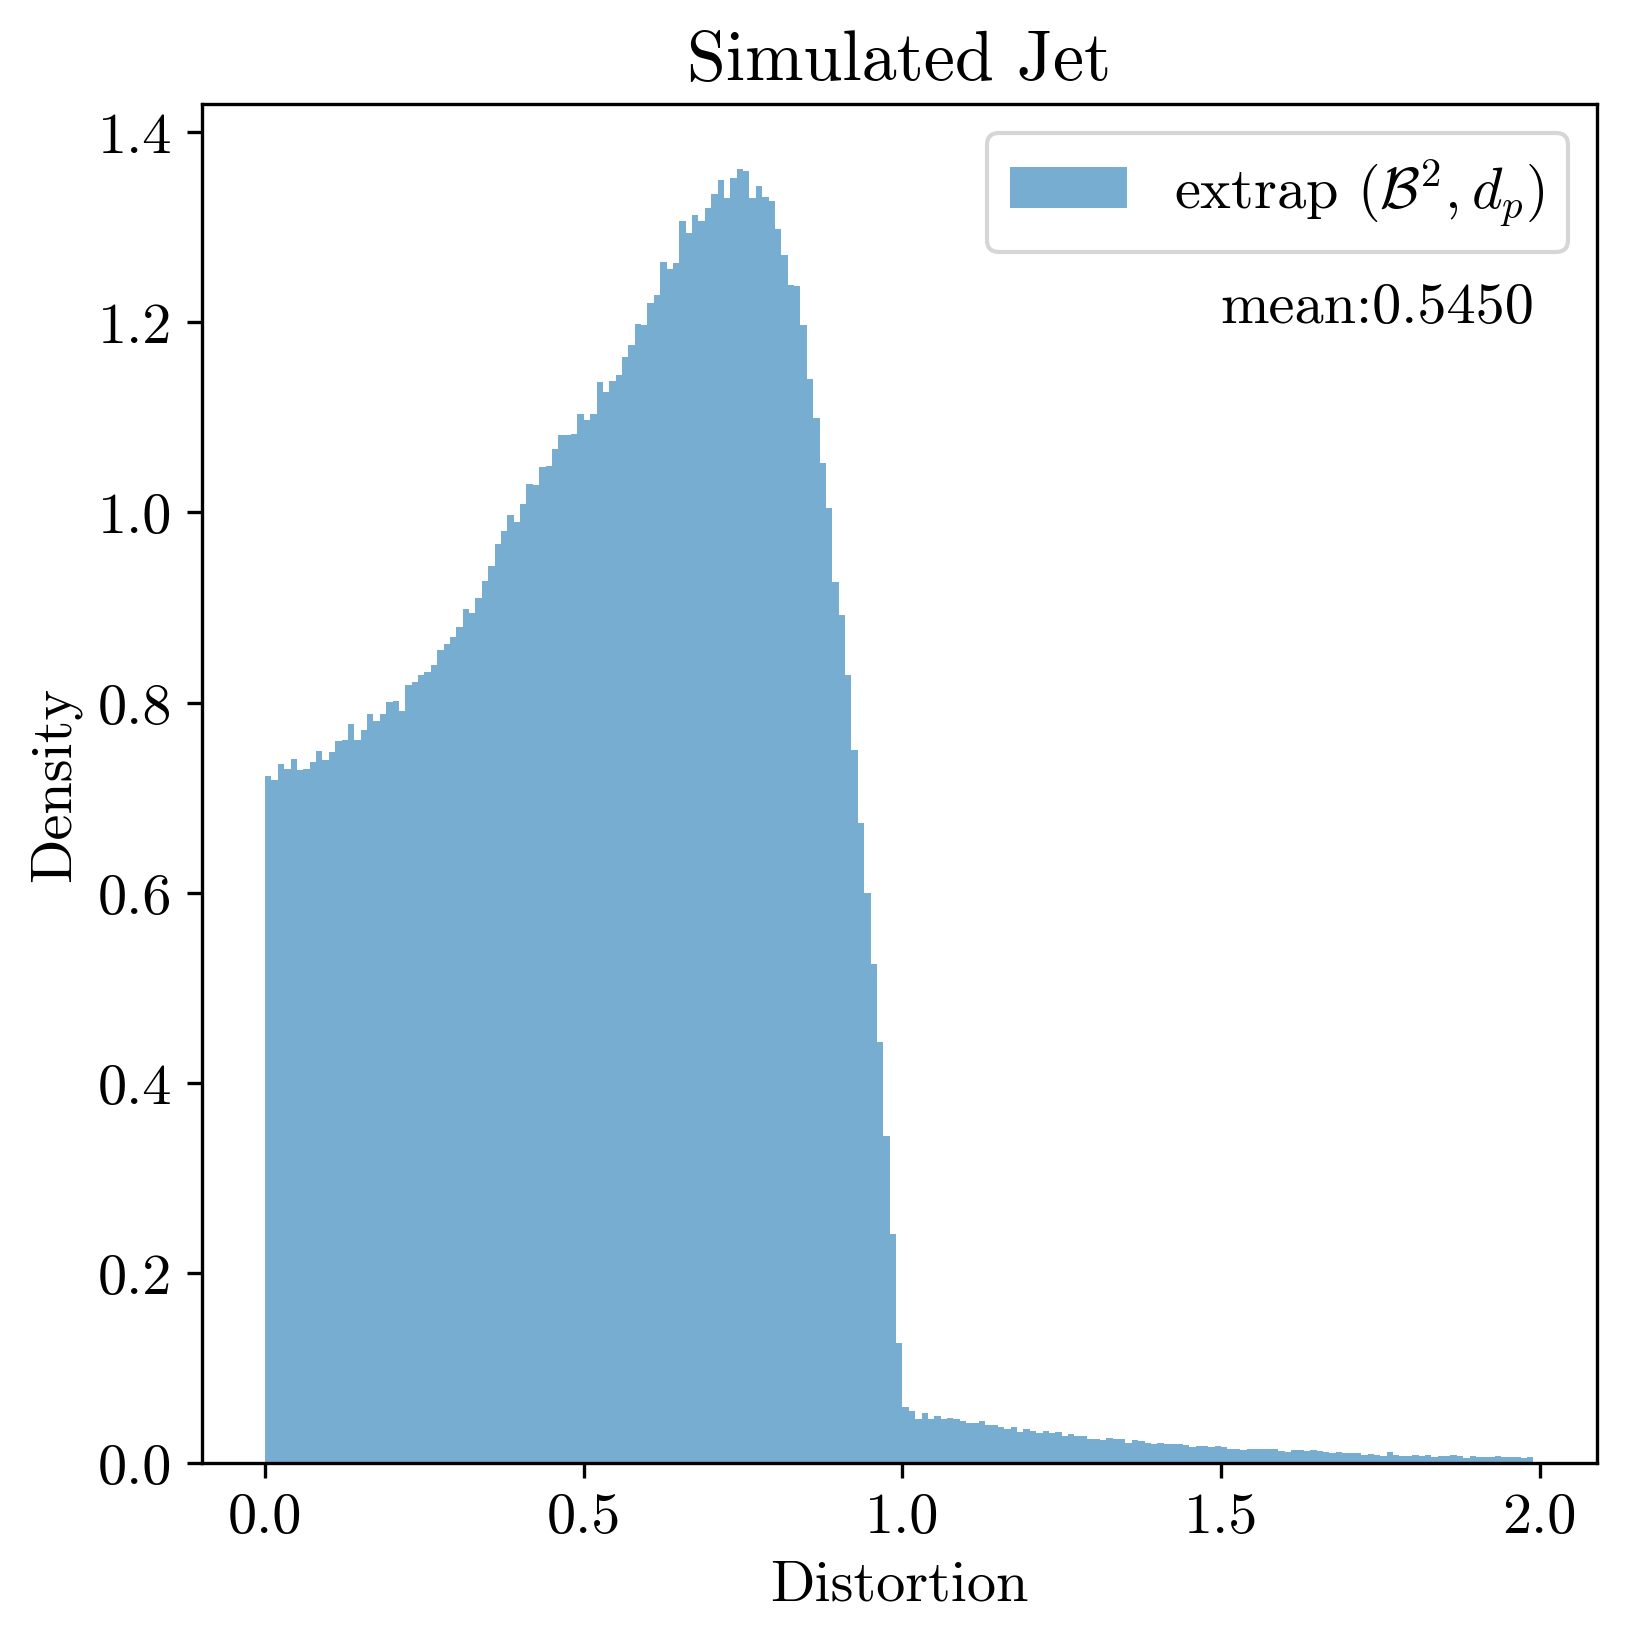

In [92]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(poin_extrap_dist, bins=np.arange(0,2,0.01),alpha=0.6, density=True,label='extrap $(\mathcal{B}^2, d_p)$');
ax.text(0.73, 0.85, f'mean:{np.mean(poin_extrap_dist):.4f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.legend()

ax.set_xlabel("Distortion")
ax.set_ylabel("Density")
#plt.yscale('log')
ax.set_title('Simulated Jet')
#ax.legend()
plt.savefig('../figures/paper/HyperbolicDistortionExtrap_SimulatedJet_Final_v0.png')
plt.savefig('../figures/paper/HyperbolicDistortionExtrap_SimulatedJet_Final_v0.pdf')

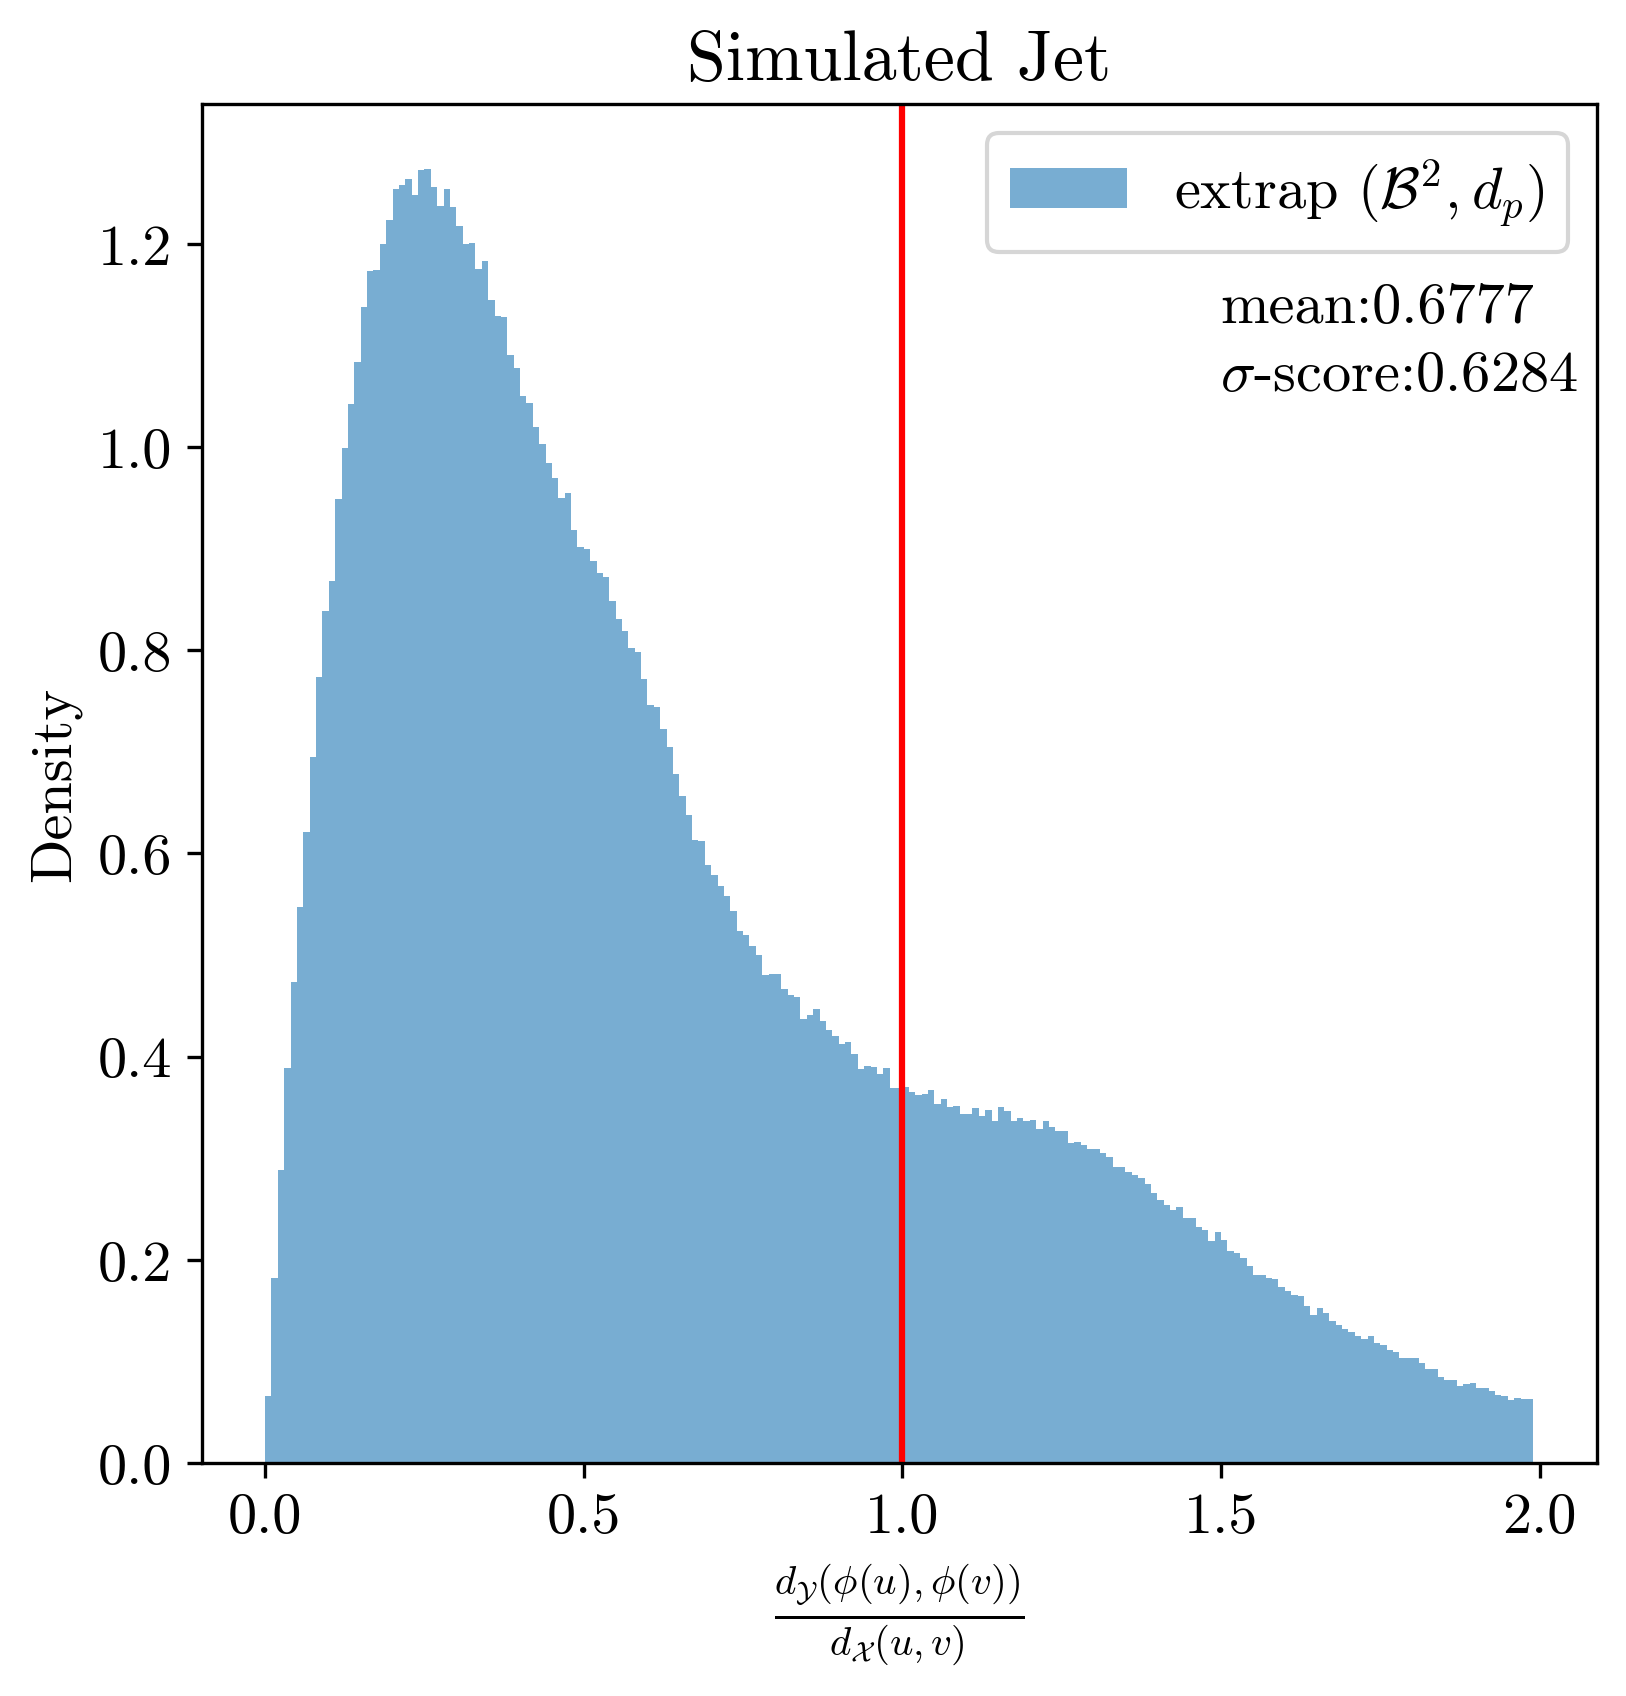

In [93]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(poin_extrap_pair, bins=np.arange(0,2,0.01),alpha=0.6, density=True,label='extrap $(\mathcal{B}^2, d_p)$');
ax.text(0.73, 0.85, f'mean:{np.mean(poin_extrap_pair):.4f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.73, 0.8, fr'$\sigma$-score:{np.var(poin_extrap_pair/np.mean(poin_extrap_pair)):.4f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.axvline(1.0, c='red')

ax.legend()

ax.set_xlabel(r"$\frac{d_\mathcal{Y}({\phi(u), \phi(v)})}{d_\mathcal{X}(u,v)}$")
ax.set_ylabel("Density")
#plt.yscale('log')
ax.set_title('Simulated Jet')
#ax.legend()
plt.savefig('../figures/paper/HyperbolicPairwiseRatioExtrap_SimulatedJet_Final_v0.png')
plt.savefig('../figures/paper/HyperbolicPairwiseRatioExtrap_SimulatedJet_Final_v0.pdf')

In [56]:
poin_interp_dist = distortion 
poin_interp_pair = pairwiseratio

In [66]:
poin_extrap_dist = distortion 
poin_extrap_pair = pairwiseratio

In [74]:
poin_interp_dist

array([0.16665994, 0.26405641, 0.1786835 , ..., 0.23708794, 0.42805276,
       0.54018567])

In [75]:
poin_extrap_dist

array([0.82907989, 0.77222066, 0.64763868, ..., 0.64419055, 0.68480832,
       0.81015463])

In [8]:
embedder = ManifoldEmbedder.load_from_checkpoint("../training/simulatedtoyjets_checkpoints/Transformer-paper-finaltuning-try14-epoch=00-val_loss=0.27.ckpt")

In [9]:
#train_file_list = []
#val_file_list = []
#test_file_list = []
#predict_file_list = []

#basedir = '/nobackup/users/sangeon/datasets/jetGridpack/jetpairs'

#for file in os.listdir(basedir):
#    if "testDistortion" in file:
#        test_file_list.append(os.path.join(basedir,file))

In [69]:
test_file_list[:3]

NameError: name 'test_file_list' is not defined

In [70]:
#test_list = []
#for file in test_file_list:
#    test_list.append(torch.load(file))
#jet_test = torch.utils.data.ConcatDataset(test_list)
#torch.save(jet_test, os.path.join(basedir, 'Gridpack_jetpair_test_measureDistortion_16part.pt'))


In [10]:
basedir_gridpack = '/nobackup/users/sangeon/datasets/jetGridpack/jetpairs'

jetgridpack_dict = {'train':None,
             'val':None,
             'test':os.path.join(basedir_gridpack, 'Gridpack_jetpair_test_measureDistortion_16part.pt'),
             'predict':None}


#toyreal = torch.load(os.path.join(basedir_toyreal, 'realistic_jettest_measureDistortion_16part.pt'))


jetgridpack_dm = JetDataModule(jetgridpack_dict,2500)


In [11]:
trainer.test(embedder, jetgridpack_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

start
euclidean:  tensor([0.1154, 0.1454], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.3780, 0.2150], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.1192, 0.3458], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.1109, 0.0185], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.0538, 0.0853], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.1071, 0.0171], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.1125, 0.2234], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.3792, 0.0715], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.1465, 0.1936], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.0307, 0.2662], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.1558, 0.0644], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.1376, 0.1604], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.1229, 0.1260], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.1968, 0.1644], device='

[{}]

In [12]:
distortion = np.empty(0)
for batch in embedder.distortion_measure:
    distortion = np.concatenate([distortion,batch.cpu().numpy()])

In [13]:
np.mean(distortion)

0.2859221952899058

In [14]:
np.std(distortion)

0.20032075763746268

In [59]:
normratio = distortion/np.mean(distortion)

In [19]:
pairwiseratio = np.empty(0)
for batch in embedder.pairwise_ratio:
    pairwiseratio = np.concatenate([pairwiseratio,batch.cpu().numpy()])

In [16]:
eucl_extrap_par = pairwiseratio

In [20]:
eucl_interp_par = pairwiseratio

In [21]:
eucl_extrap_pair = eucl_extrap_par

In [22]:
eucl_interp_pair = eucl_interp_par

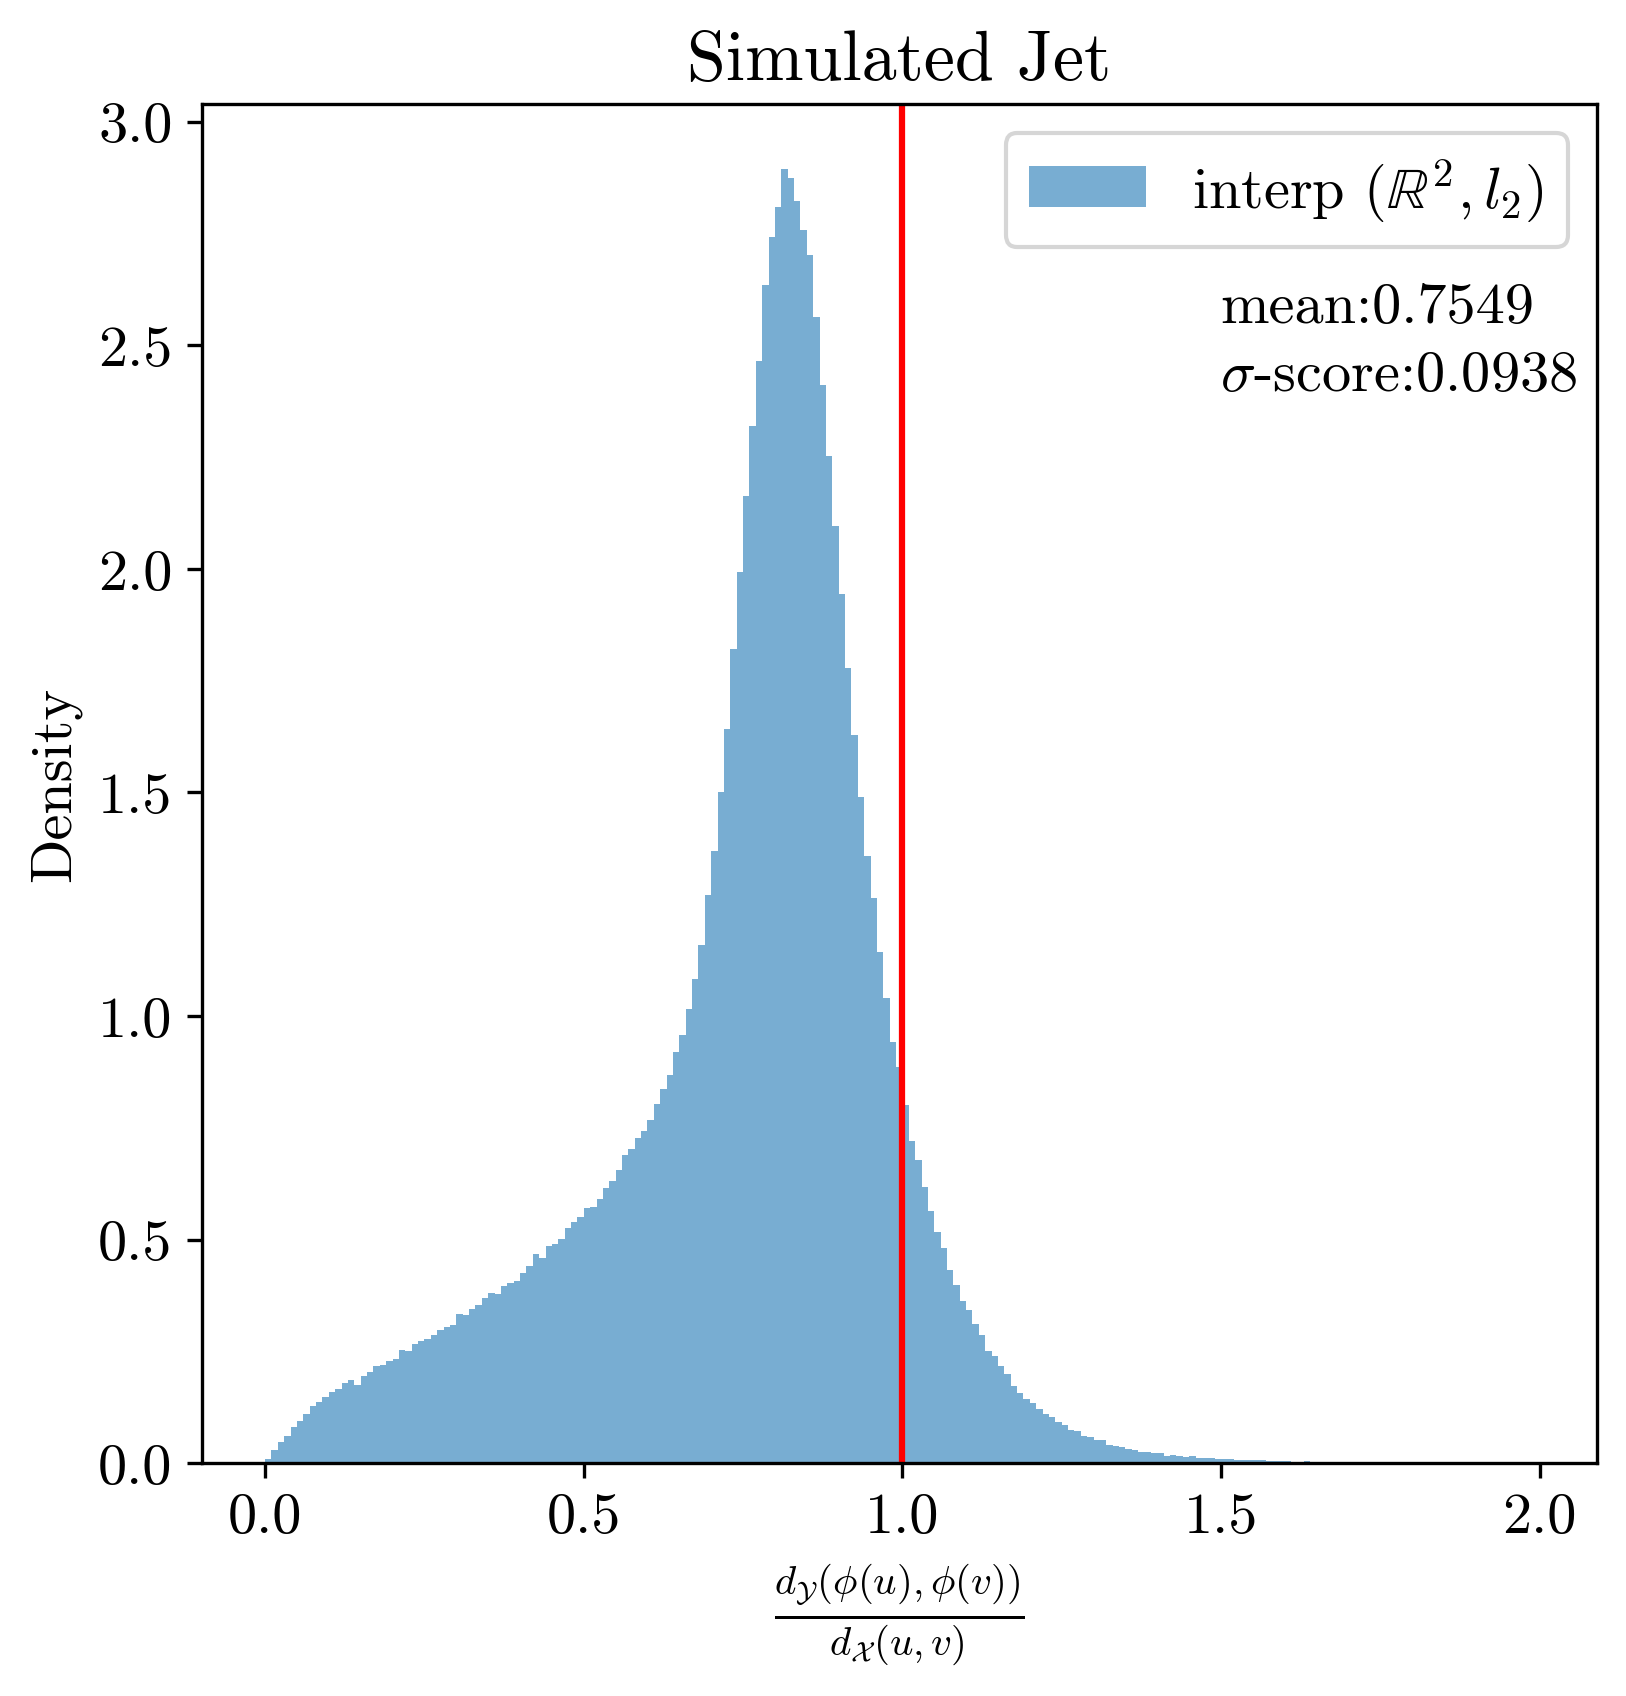

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(eucl_interp_pair, bins=np.arange(0,2,0.01),alpha=0.6, density=True,label='interp $(\mathbb{R}^2, l_2)$');
ax.text(0.73, 0.85, f'mean:{np.mean(eucl_interp_pair):.4f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.73, 0.8, fr'$\sigma$-score:{np.var(eucl_interp_pair/np.mean(eucl_interp_pair)):.4f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.axvline(1.0, c='red')

ax.legend()

ax.set_xlabel(r"$\frac{d_\mathcal{Y}({\phi(u), \phi(v)})}{d_\mathcal{X}(u,v)}$")
ax.set_ylabel("Density")
#plt.yscale('log')
ax.set_title('Simulated Jet')
#ax.legend()
plt.savefig('../figures/paper/EuclideanPairwiseRatioInterp_SimulatedJet_Final_v0.png')
plt.savefig('../figures/paper/EuclideanPairwiseRatioInterp_SimulatedJet_Final_v0.pdf')

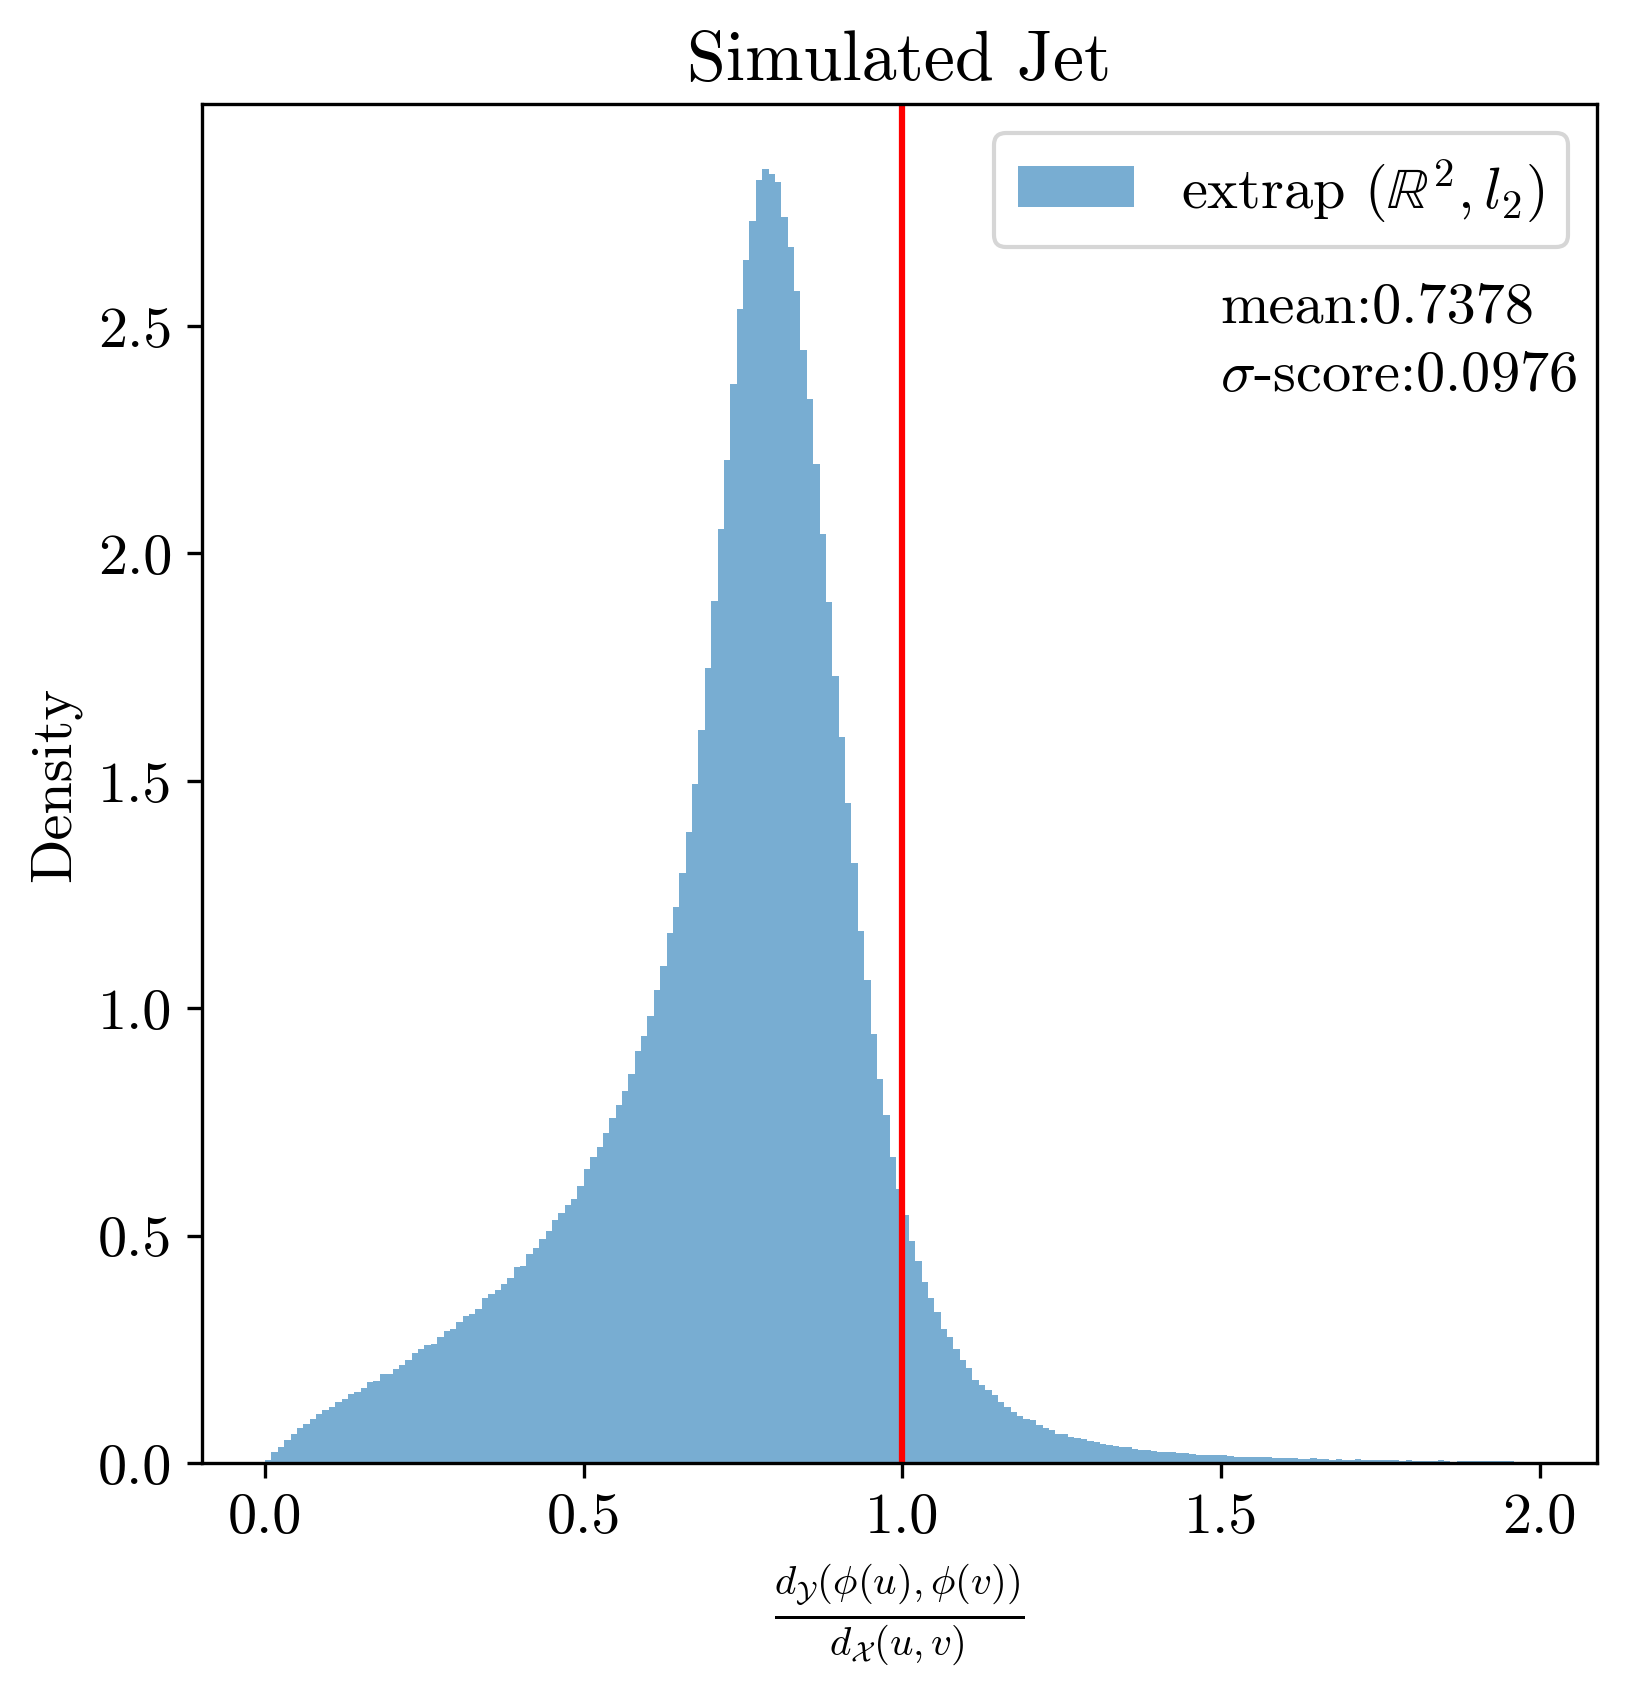

In [27]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(eucl_extrap_pair, bins=np.arange(0,2,0.01),alpha=0.6, density=True,label='extrap $(\mathbb{R}^2, l_2)$');
ax.text(0.73, 0.85, f'mean:{np.mean(eucl_extrap_pair):.4f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.73, 0.8, fr'$\sigma$-score:{np.var(eucl_extrap_pair/np.mean(eucl_extrap_pair)):.4f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.axvline(1.0, c='red')

ax.legend()

ax.set_xlabel(r"$\frac{d_\mathcal{Y}({\phi(u), \phi(v)})}{d_\mathcal{X}(u,v)}$")
ax.set_ylabel("Density")
#plt.yscale('log')
ax.set_title('Simulated Jet')
#ax.legend()
plt.savefig('../figures/paper/EuclideanPairwiseRatioExtrap_SimulatedJet_Final_v0.png')
plt.savefig('../figures/paper/EuclideanPairwiseRatioExtrap_SimulatedJet_Final_v0.pdf')

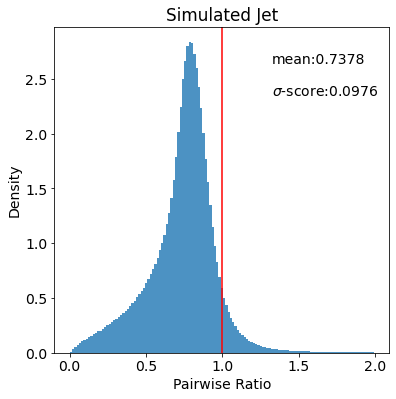

In [104]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(distortion, bins=np.arange(0,2,0.015),alpha=0.8, density=True,label='Simulated Jet')
ax.text(0.65, 0.9, f'mean:{np.mean(distortion):.4f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.65, 0.8, fr'$\sigma$-score:{np.var(normratio):.4f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.axvline(1.0, c='red')
ax.set_xlabel("Pairwise Ratio")
ax.set_ylabel("Density")
#plt.yscale('log')
ax.set_title('Simulated Jet')
#ax.legend()
plt.savefig('../figures/paper/Distortion_SimulatedJet_Final_v0.png')
plt.savefig('../figures/paper/Distortion_SimulatedJet_Final_v0.pdf')

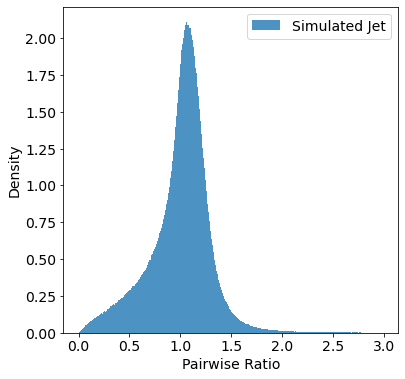

In [61]:
plt.hist(normratio, bins=np.arange(0,3,0.01),alpha=0.8, density=True,label='Simulated Jet')

plt.xlabel("Pairwise Ratio")
plt.ylabel("Density")
#plt.yscale('log')
#plt.title('Distortion Simulated Jet')
plt.legend()

In [23]:
interpolate_test_file_list = []

basedir = '/nobackup/users/sangeon/datasets/jetGridpack/jetpairs'

for file in os.listdir(basedir):
    if "interpolateDistortion" in file:
        interpolate_test_file_list.append(os.path.join(basedir,file))

In [24]:
interpolate_test_file_list

['/nobackup/users/sangeon/datasets/jetGridpack/jetpairs/Gridpack_jetpair_interpolateDistortion_16part_18.pt',
 '/nobackup/users/sangeon/datasets/jetGridpack/jetpairs/Gridpack_jetpair_interpolateDistortion_16part_5.pt',
 '/nobackup/users/sangeon/datasets/jetGridpack/jetpairs/Gridpack_jetpair_interpolateDistortion_16part_13.pt',
 '/nobackup/users/sangeon/datasets/jetGridpack/jetpairs/Gridpack_jetpair_interpolateDistortion_16part_19.pt',
 '/nobackup/users/sangeon/datasets/jetGridpack/jetpairs/Gridpack_jetpair_test_interpolateDistortion_16part.pt',
 '/nobackup/users/sangeon/datasets/jetGridpack/jetpairs/Gridpack_jetpair_interpolateDistortion_16part_9.pt',
 '/nobackup/users/sangeon/datasets/jetGridpack/jetpairs/Gridpack_jetpair_interpolateDistortion_16part_7.pt',
 '/nobackup/users/sangeon/datasets/jetGridpack/jetpairs/Gridpack_jetpair_interpolateDistortion_16part_23.pt',
 '/nobackup/users/sangeon/datasets/jetGridpack/jetpairs/Gridpack_jetpair_interpolateDistortion_16part_11.pt',
 '/nobackup

In [22]:
interpolate_list = []
for file in interpolate_test_file_list:
    interpolate_list.append(torch.load(file))
jet_test = torch.utils.data.ConcatDataset(interpolate_list)
torch.save(jet_test, os.path.join(basedir, 'Gridpack_jetpair_test_interpolateDistortion_16part.pt'))


NameError: name 'interpolate_test_file_list' is not defined

In [17]:
basedir_gridpack = '/nobackup/users/sangeon/datasets/jetGridpack/jetpairs'

jetgridpack_dict = {'train':None,
             'val':None,
             'test':os.path.join(basedir_gridpack, 'Gridpack_jetpair_test_interpolateDistortion_16part.pt'),
             'predict':None}


#toyreal = torch.load(os.path.join(basedir_toyreal, 'realistic_jettest_measureDistortion_16part.pt'))


jetgridpack_dm = JetDataModule(jetgridpack_dict,2500)


In [18]:
trainer.test(embedder, jetgridpack_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

start
euclidean:  tensor([0.0822, 0.0885], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.1186, 0.1692], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.1228, 0.2763], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.0780, 0.1856], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.0872, 0.0231], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.1030, 0.1076], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.1104, 0.1252], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.1849, 0.3103], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.1120, 0.1205], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.1295, 0.3928], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.1354, 0.0419], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.0493, 0.0567], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.0798, 0.1311], device='cuda:0')
torch.Size([2500])
euclidean:  tensor([0.1504, 0.1993], device='

[{}]

In [98]:
distortion2 = np.empty(0)
for batch in embedder.distortion_measure:
    distortion2 = np.concatenate([distortion2,batch.cpu().numpy()])

In [100]:
normratio2 = distortion2/np.mean(distortion2)

In [102]:
np.mean(normratio2)

0.9999999999999997

Text(0.5, 1.0, 'Simulated Jet - Interpolate')

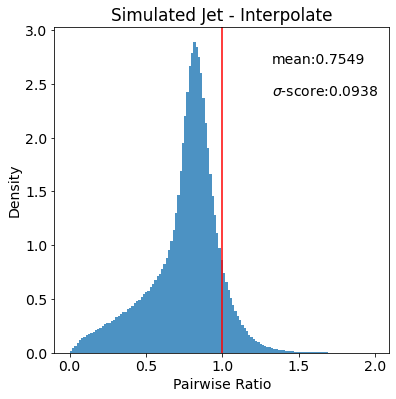

In [103]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(distortion2, bins=np.arange(0,2,0.015),alpha=0.8, density=True,label='Simulated Jet')
ax.text(0.65, 0.9, f'mean:{np.mean(distortion2):.4f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.65, 0.8, fr'$\sigma$-score:{np.var(normratio2):.4f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.axvline(1.0, c='red')
ax.set_xlabel("Pairwise Ratio")
ax.set_ylabel("Density")
#plt.yscale('log')
ax.set_title('Simulated Jet - Interpolate')
#ax.legend()
#plt.savefig('../figures/paper/Distortion_SimulatedJet_normalscale.png')
#plt.savefig('../figures/paper/Distortion_SimulatedJet_normalscale.pdf')